# Zipline algorithm analysis example in pyfolio

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports
Import pyfolio, along with the necessary modules for running our zipline backtest.

In [1]:
%matplotlib inline
import pyfolio as pf

/home/saeed/anaconda3/envs/py34/lib/python3.4/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import sys
import logbook
import numpy as np
from datetime import datetime
import pytz

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission

AttributeError: 'module' object has no attribute 'create_module_class_proxy'

## Run our zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [3]:
# Zipline trading algorithm
# Taken from zipline.examples.olmar
zipline_logging = logbook.NestedSetup([
    logbook.NullHandler(level=logbook.DEBUG),
    logbook.StreamHandler(sys.stdout, level=logbook.INFO),
    logbook.StreamHandler(sys.stderr, level=logbook.ERROR),
])
zipline_logging.push_application()

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w


start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)

# Load price data from yahoo.
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()

# Create and run the algorithm.
olmar = TradingAlgorithm(handle_data=handle_data, initialize=initialize)
results = olmar.run(data)

NameError: name 'load_from_yahoo' is not defined

## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [4]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

## Single plot example
Make one plot of the top 5 drawdown periods.

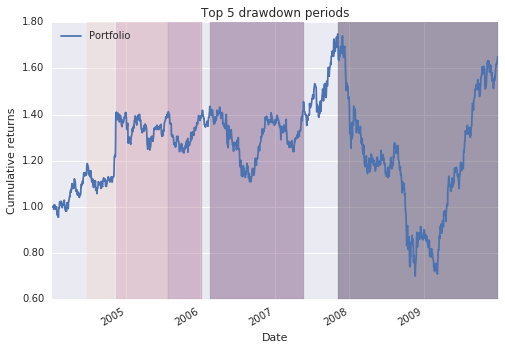

In [5]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics   All history  Backtest  Out of sample
annual_return                   0.08      0.08           0.03
cum_returns_final               0.62      0.58           0.01
annual_volatility               0.25      0.26           0.22
sharpe_ratio                    0.44      0.43           0.25
calmar_ratio                    0.14      0.14           0.42
stability_of_timeseries         0.00      0.01           0.05
max_drawdown                   -0.60     -0.60          -0.07
omega_ratio                     1.08      1.08           1.04
sortino_ratio                   0.65      0.64           0.34
skew                            0.27      0.28          -0.28
kurtosis                        4.05      4.10           0.47
tail_ratio                      0.97      0.99           1.24
common_sense_ratio              1.05      1.07           1.27
gross_leverage                  1.00      1.00           1.00
information_ratio               0.02      0.02          -0.05
alpha                           0.08      0.08          -0.11
beta                            0.81      0.81           1.18

Worst drawdown periods net drawdown in %  peak date valley date recovery date  \
0                                  59.92 2007-11-06  2008-11-20           NaT   
1                                  22.74 2006-02-16  2006-08-31    2007-05-22   
2                                  12.68 2005-07-28  2005-10-12    2006-01-11   
3                                  11.66 2004-11-15  2005-04-28    2005-07-28   
4                                  10.96 2004-06-25  2004-08-12    2004-11-05   

Worst drawdown periods duration  
0                           NaN  
1                           329  
2                           120  
3                           184  
4                            96



[-0.032 -0.069]


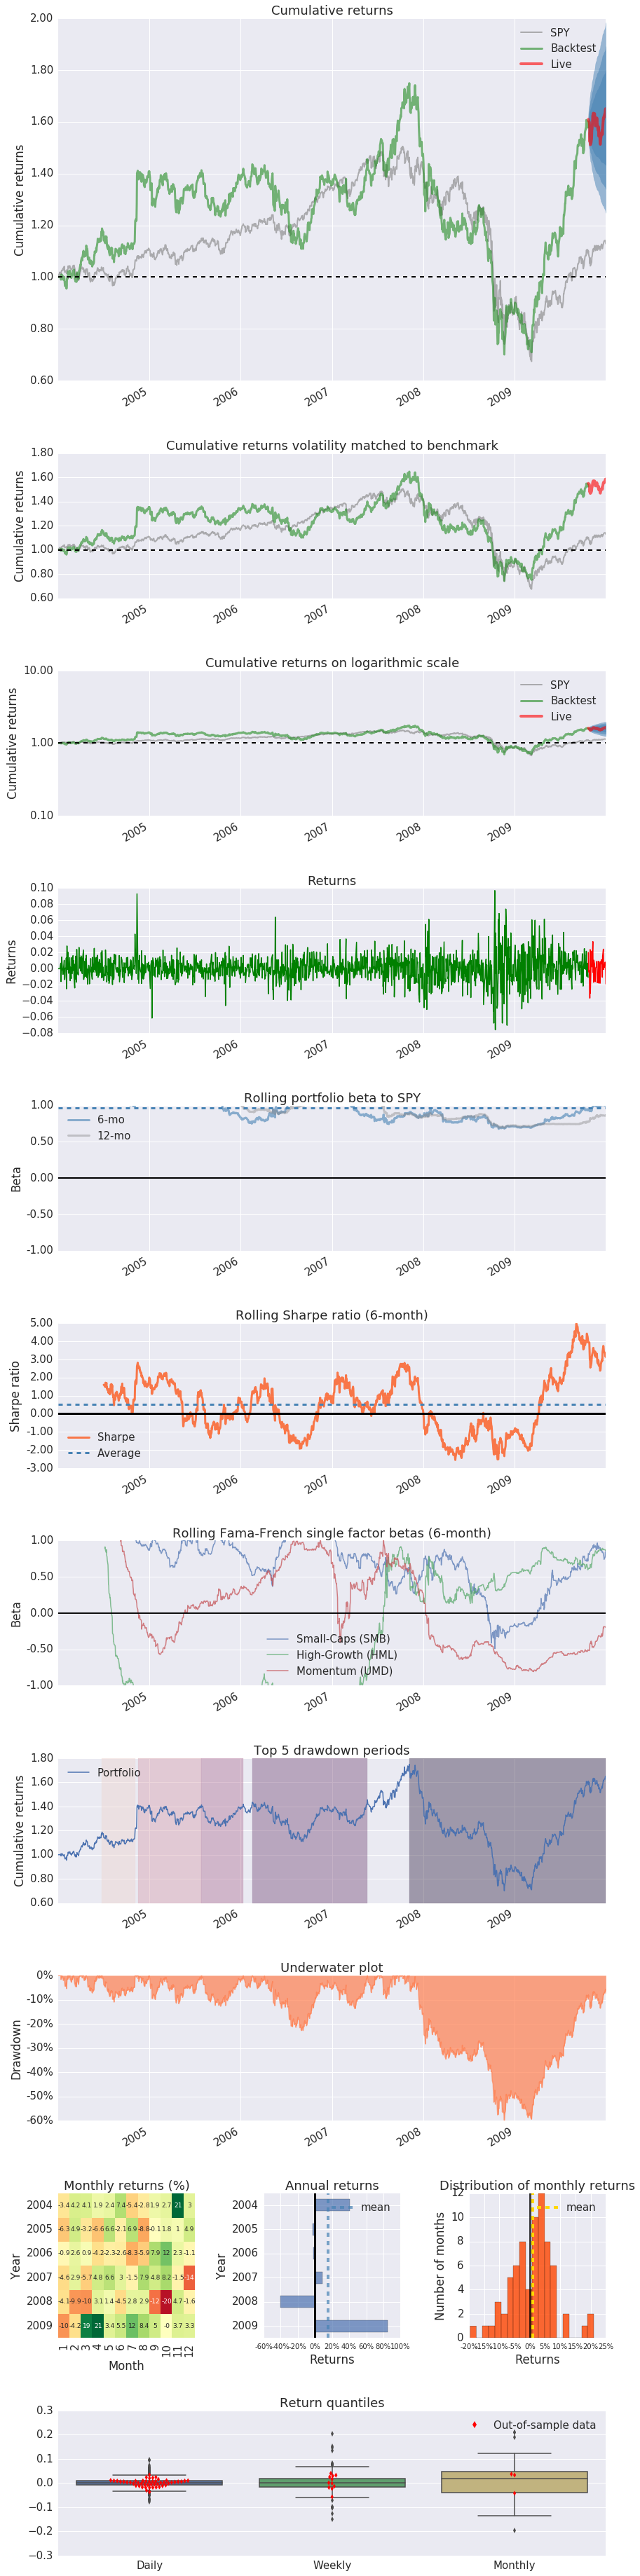

/opt/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events                mean    min   max
Lehmann                    -0.26% -4.46% 4.41%
Aug07                       0.34% -2.96% 3.02%
Mar08                      -0.44% -3.10% 3.33%
Sept08                     -0.64% -4.35% 3.99%
2009Q1                     -0.36% -4.99% 3.35%
2009Q2                      0.71% -3.78% 6.16%
Low Volatility Bull Market  0.01% -6.13% 6.40%
GFC Crash                  -0.08% -7.59% 9.70%
Recovery                    0.32% -3.78% 6.16%

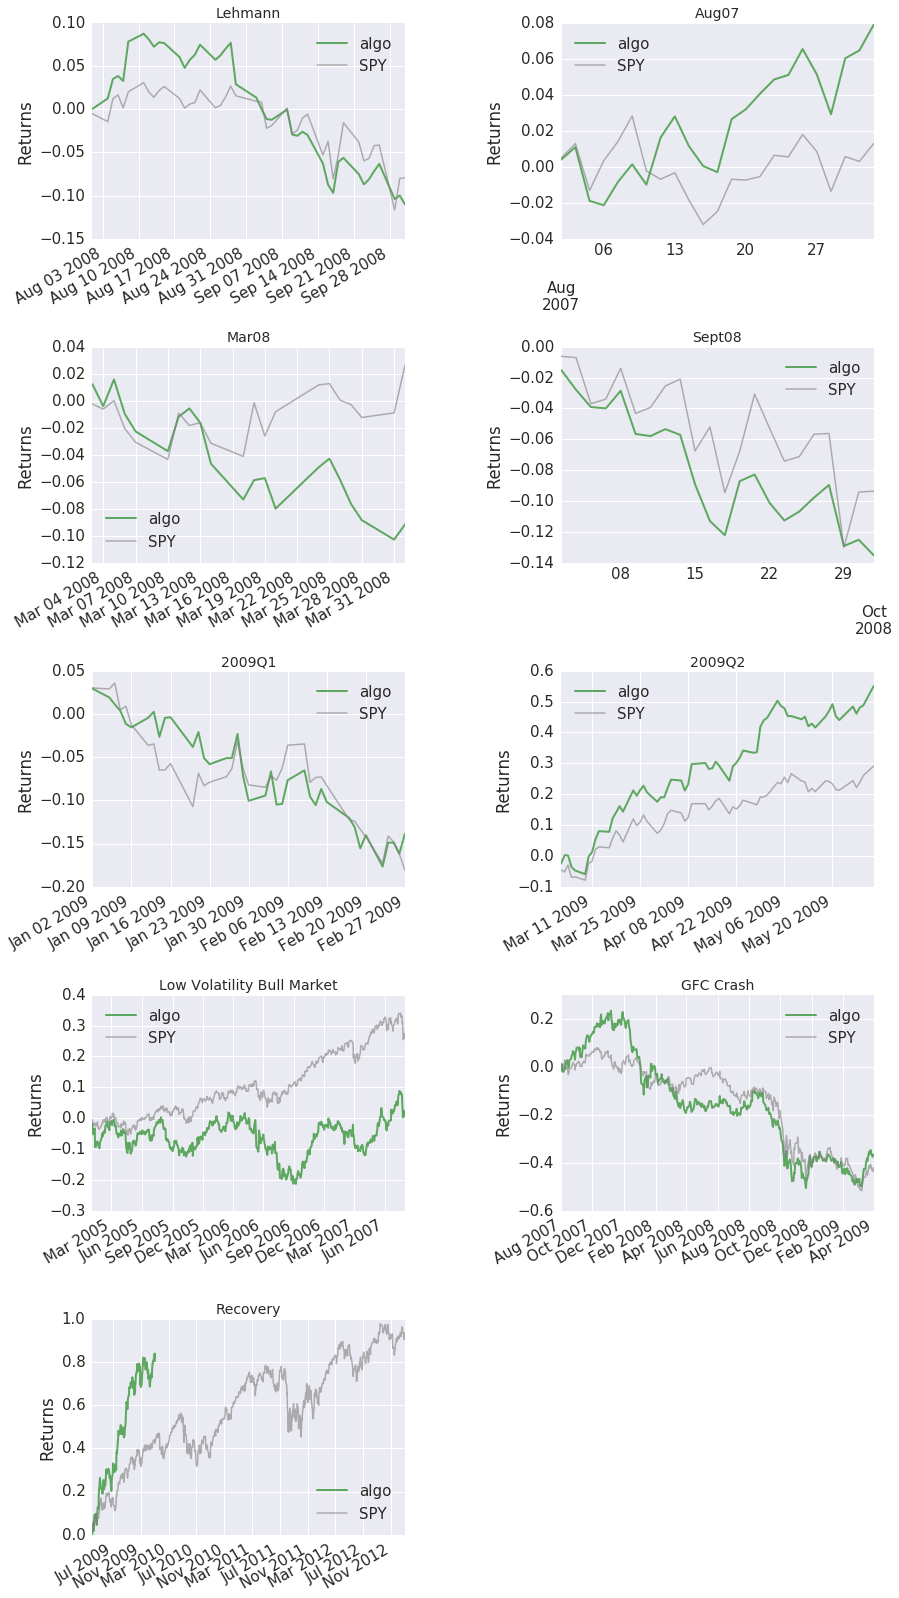

Top 10 long positions of all time     max
sid                                      
Equity(5 [COST])                  100.75%
Equity(4 [MMM])                    92.35%
Equity(1 [CERN])                   84.49%
Equity(3 [DELL])                   71.71%
Equity(2 [AMD])                    71.05%
Equity(0 [INTC])                   66.70%
Equity(6 [GPS])                    62.11%

Empty DataFrame
Columns: [max]
Index: []

Top 10 positions of all time     max
sid                                 
Equity(5 [COST])             100.75%
Equity(4 [MMM])               92.35%
Equity(1 [CERN])              84.49%
Equity(3 [DELL])              71.71%
Equity(2 [AMD])               71.05%
Equity(0 [INTC])              66.70%
Equity(6 [GPS])               62.11%

All positions ever held     max
sid                            
Equity(5 [COST])        100.75%
Equity(4 [MMM])          92.35%
Equity(1 [CERN])         84.49%
Equity(3 [DELL])         71.71%
Equity(2 [AMD])          71.05%
Equity(0 [INTC])         66.70%
Equity(6 [GPS])          62.11%

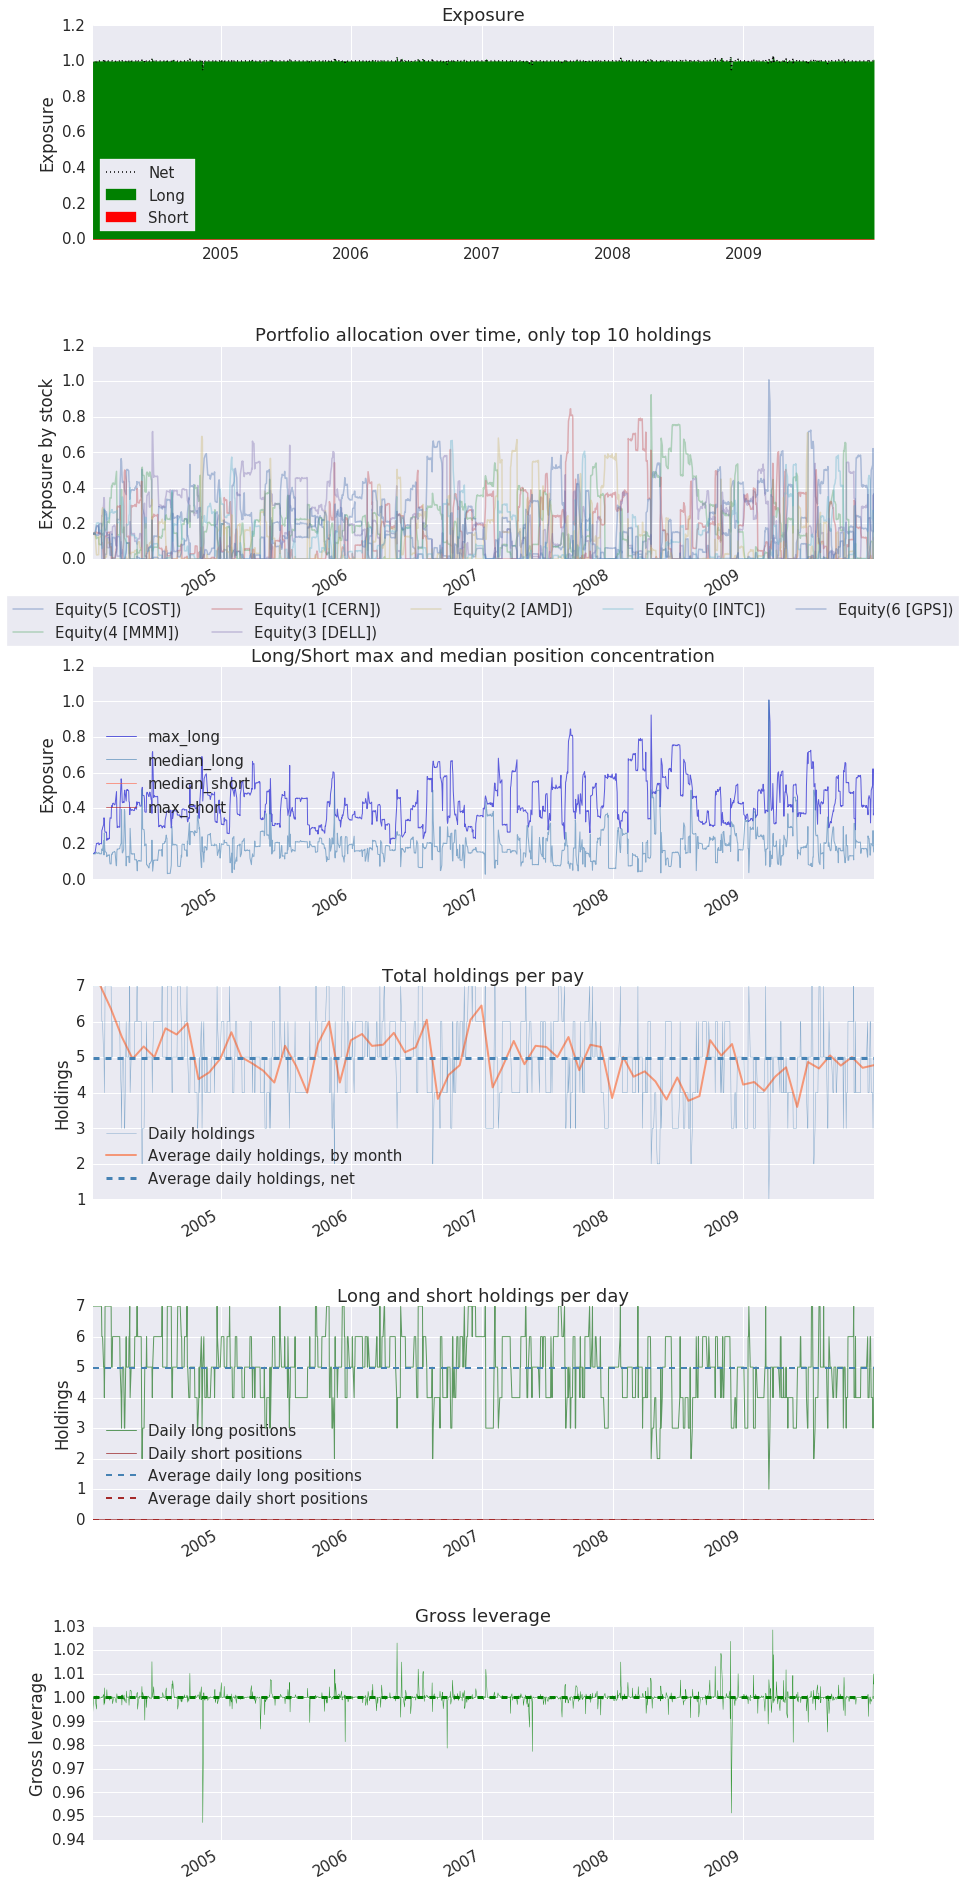

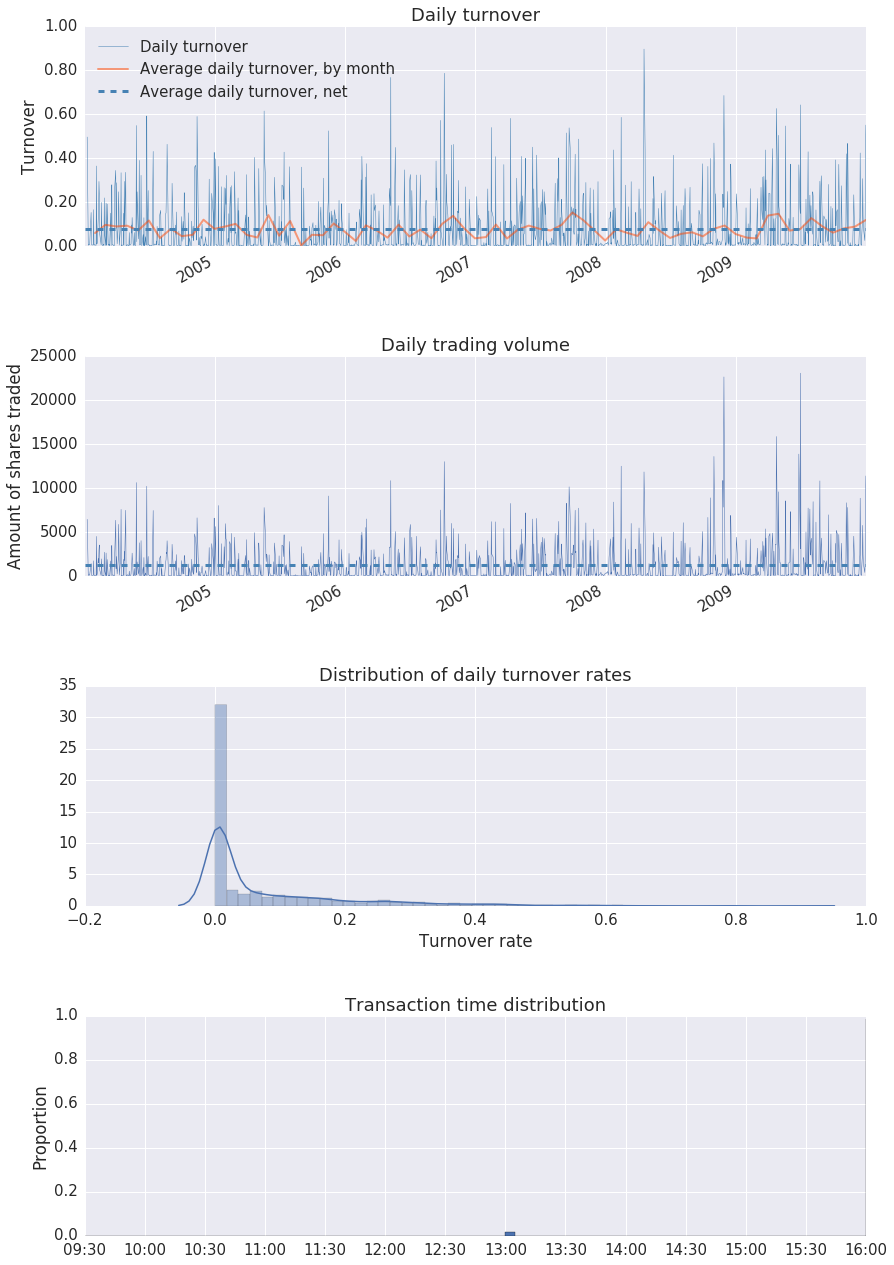

Summary stats                All trades  Short trades  Long trades
Total number of round_trips     3740.00          3.00      3737.00
Percent profitable                 0.49          0.00         0.49
Winning round_trips             1836.00          0.00      1836.00
Losing round_trips              1904.00          3.00      1901.00
Even round_trips                   0.00          0.00         0.00

PnL stats                 All trades  Short trades  Long trades
Total profit               $69337.34        $-0.00    $69337.34
Gross profit              $381330.89         $0.00   $381330.89
Gross loss               $-311993.54        $-0.00  $-311993.54
Profit factor                  $1.22         $0.00        $1.22
Avg. trade net profit         $18.54        $-0.00       $18.55
Avg. winning trade           $207.70          $nan      $207.70
Avg. losing trade           $-163.86        $-0.00     $-164.12
Ratio Avg. Win:Avg. Loss       $1.27          $nan        $1.27
Largest winning trade      $15549.28        $-0.00    $15549.28
Largest losing trade      $-12474.06        $-0.00   $-12474.06

Duration stats               All trades  Short trades             Long trades
Avg duration    22 days 05:19:36.256684      20:59:59 22 days 05:44:16.891356
Median duration        18 days 00:00:00      20:59:59        18 days 00:00:00

Return stats                    All trades  Short trades  Long trades
Avg returns all round_trips          0.01%        -0.00%        0.01%
Avg returns winning                  0.17%          nan%        0.17%
Avg returns losing                  -0.14%        -0.00%       -0.14%
Median returns all round_trips      -0.00%        -0.00%       -0.00%
Median returns winning               0.02%          nan%        0.02%
Median returns losing               -0.01%        -0.00%       -0.01%
Largest winning trade               12.13%        -0.00%       12.13%
Largest losing trade                -9.14%        -0.00%       -9.14%

Symbol stats                    Equity(0 [INTC])  Equity(1 [CERN])  \
Avg returns all round_trips                0.04%             0.03%   
Avg returns winning                        0.17%             0.20%   
Avg returns losing                        -0.07%            -0.17%   
Median returns all round_trips            -0.00%             0.00%   
Median returns winning                     0.04%             0.02%   
Median returns losing                     -0.00%            -0.01%   
Largest winning trade                      2.34%             5.92%   
Largest losing trade                      -4.60%            -4.67%   

Symbol stats                    Equity(2 [AMD])  Equity(3 [DELL])  \
Avg returns all round_trips               0.00%            -0.04%   
Avg returns winning                       0.38%             0.13%   
Avg returns losing                       -0.36%            -0.19%   
Median returns all round_trips           -0.00%            -0.00%   
Median returns winning                    0.07%             0.01%   
Median returns losing                    -0.02%            -0.01%   
Largest winning trade                    12.13%             2.49%   
Largest losing trade                     -9.14%            -5.87%   

Symbol stats                    Equity(4 [MMM])  Equity(5 [COST])  \
Avg returns all round_trips               0.01%             0.03%   
Avg returns winning                       0.11%             0.13%   
Avg returns losing                       -0.09%            -0.06%   
Median returns all round_trips            0.00%            -0.00%   
Median returns winning                    0.01%             0.01%   
Median returns losing                    -0.01%            -0.01%   
Largest winning trade                     2.24%             2.95%   
Largest losing trade                     -3.82%            -3.41%   

Symbol stats                    Equity(6 [GPS])  
Avg returns all round_trips              -0.00%  
Avg returns winning                       0.13%  
Avg returns losing                       -0.11%  
Median returns all round_trips           -0.00%  
Median returns winning                    0.02%  
Median returns losing                    -0.01%  
Largest winning trade                     3.53%  
Largest losing trade                     -8.28%

Profitability (PnL / PnL total) per name    pnl
symbol                                         
Equity(0 [INTC])                          0.40%
Equity(5 [COST])                          0.37%
Equity(1 [CERN])                          0.32%
Equity(4 [MMM])                           0.18%
Equity(6 [GPS])                           0.04%
Equity(2 [AMD])                          -0.04%
Equity(3 [DELL])                         -0.27%

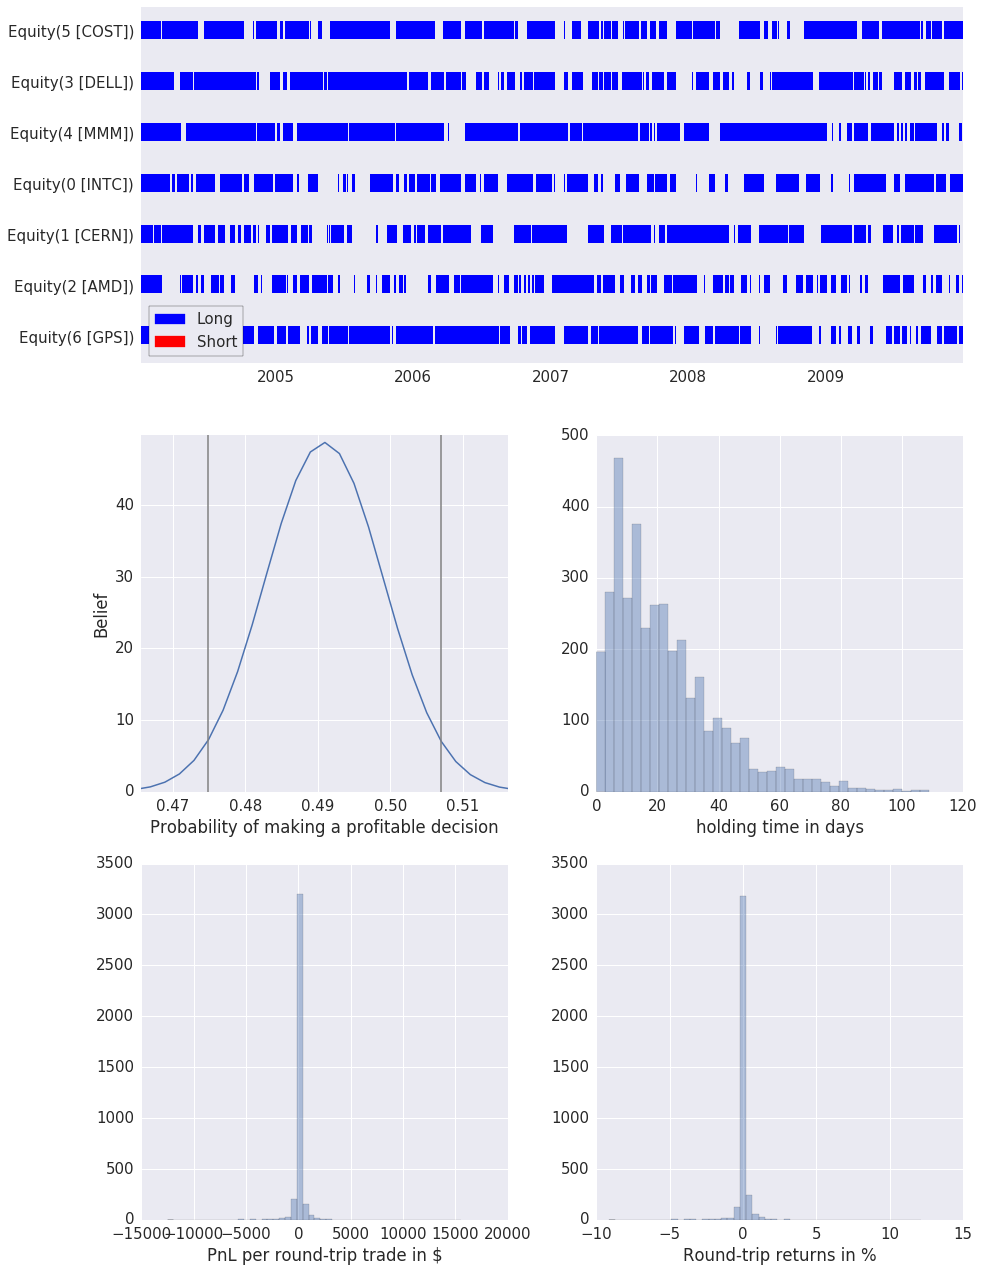

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', round_trips=True)

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics   All history  Backtest  Out of sample
annual_return                   0.08      0.08           0.03
cum_returns_final               0.62      0.58           0.01
annual_volatility               0.25      0.26           0.22
sharpe_ratio                    0.44      0.43           0.25
calmar_ratio                    0.14      0.14           0.42
stability_of_timeseries         0.00      0.01           0.05
max_drawdown                   -0.60     -0.60          -0.07
omega_ratio                     1.08      1.08           1.04
sortino_ratio                   0.65      0.64           0.34
skew                            0.27      0.28          -0.28
kurtosis                        4.05      4.10           0.47
tail_ratio                      0.97      0.99           1.24
common_sense_ratio              1.05      1.07           1.27
gross_leverage                  1.00      1.00           1.00
information_ratio               0.02      0.02          -0.05
alpha                           0.08      0.08          -0.11
beta                            0.81      0.81           1.18

Worst drawdown periods net drawdown in %  peak date valley date recovery date  \
0                                  59.92 2007-11-06  2008-11-20           NaT   
1                                  22.74 2006-02-16  2006-08-31    2007-05-22   
2                                  12.68 2005-07-28  2005-10-12    2006-01-11   
3                                  11.66 2004-11-15  2005-04-28    2005-07-28   
4                                  10.96 2004-06-25  2004-08-12    2004-11-05   

Worst drawdown periods duration  
0                           NaN  
1                           329  
2                           120  
3                           184  
4                            96



[-0.032 -0.069]


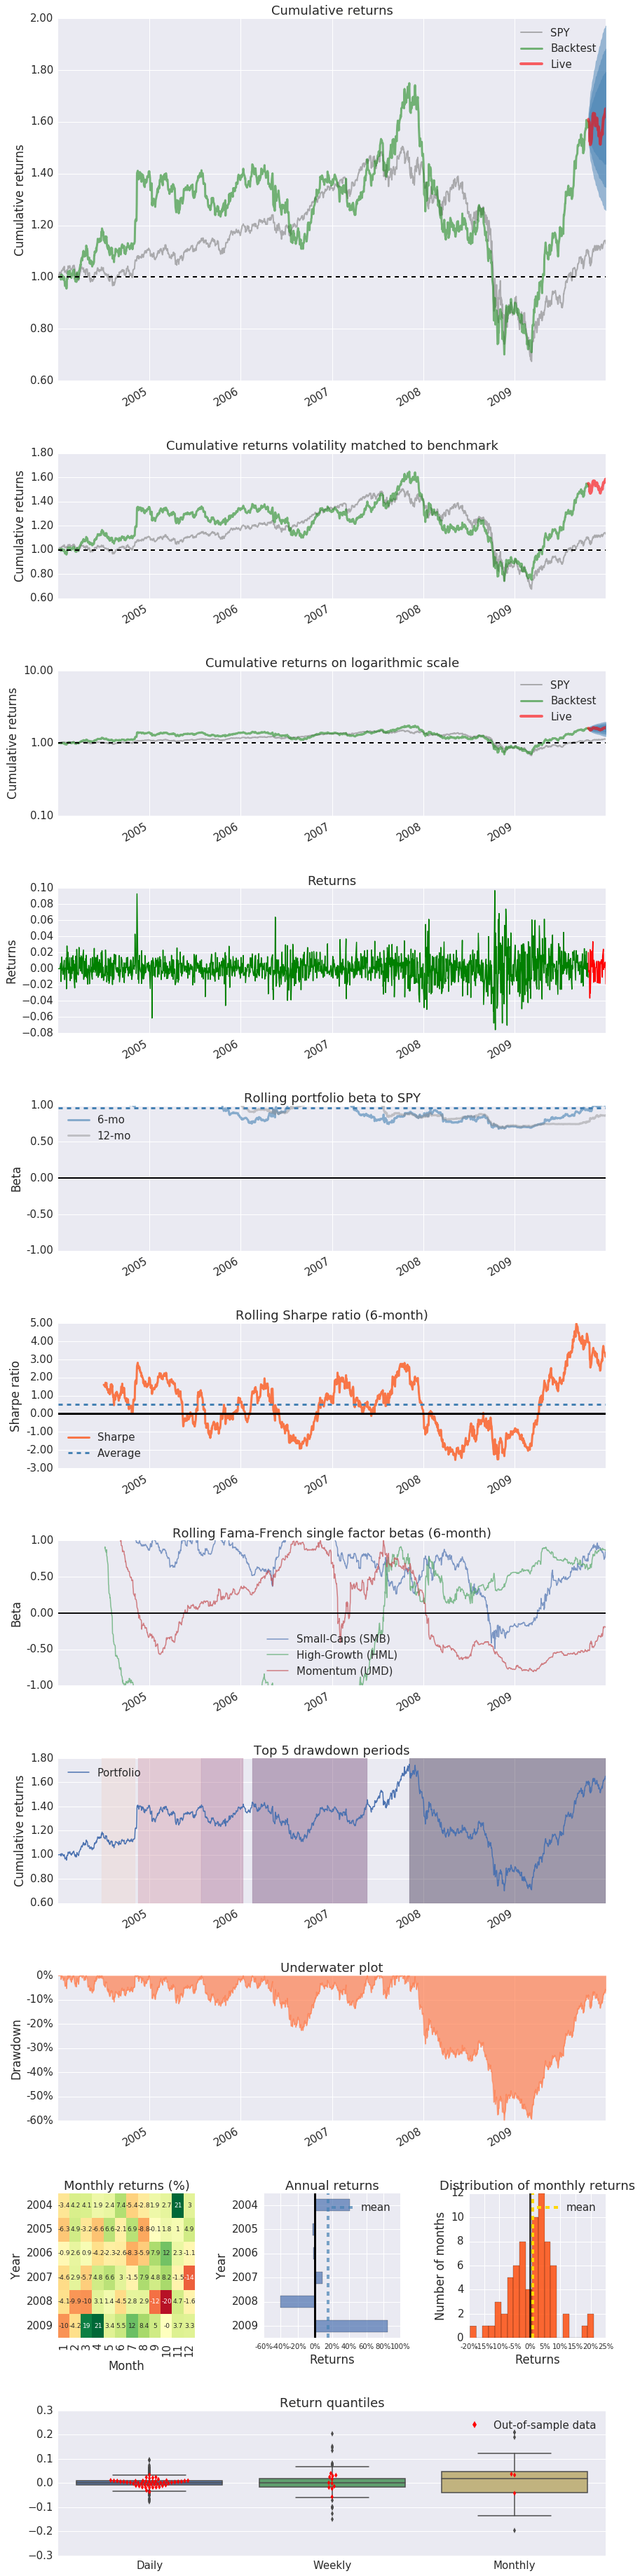

Stress Events                mean    min   max
Lehmann                    -0.26% -4.46% 4.41%
Aug07                       0.34% -2.96% 3.02%
Mar08                      -0.44% -3.10% 3.33%
Sept08                     -0.64% -4.35% 3.99%
2009Q1                     -0.36% -4.99% 3.35%
2009Q2                      0.71% -3.78% 6.16%
Low Volatility Bull Market  0.01% -6.13% 6.40%
GFC Crash                  -0.08% -7.59% 9.70%
Recovery                    0.32% -3.78% 6.16%

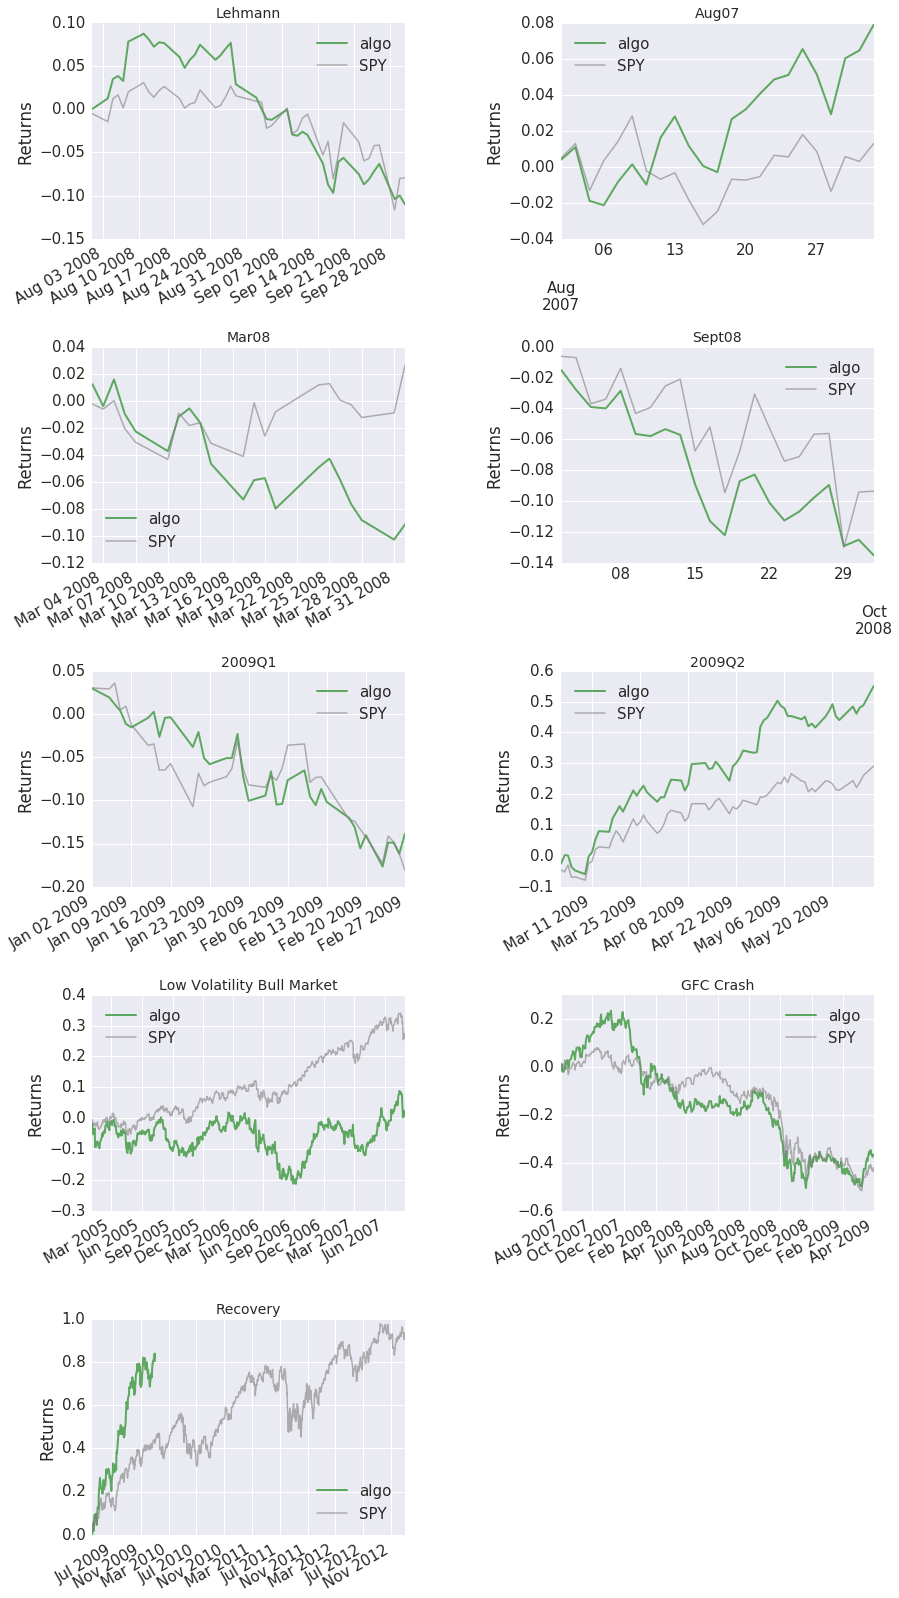

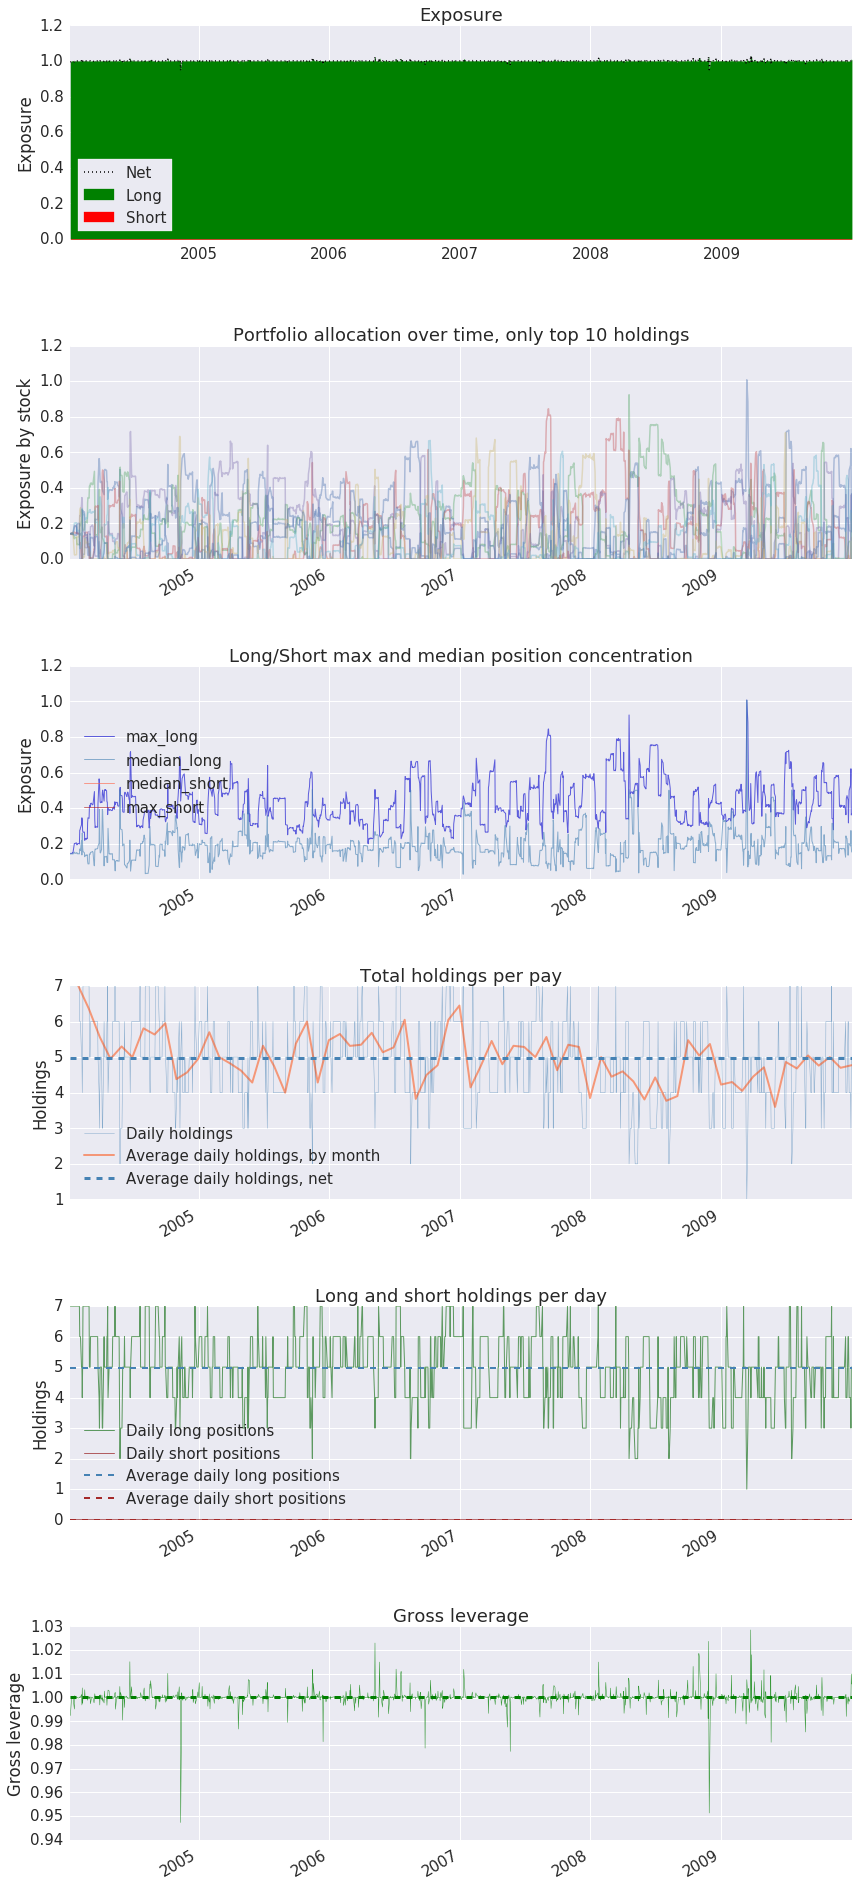

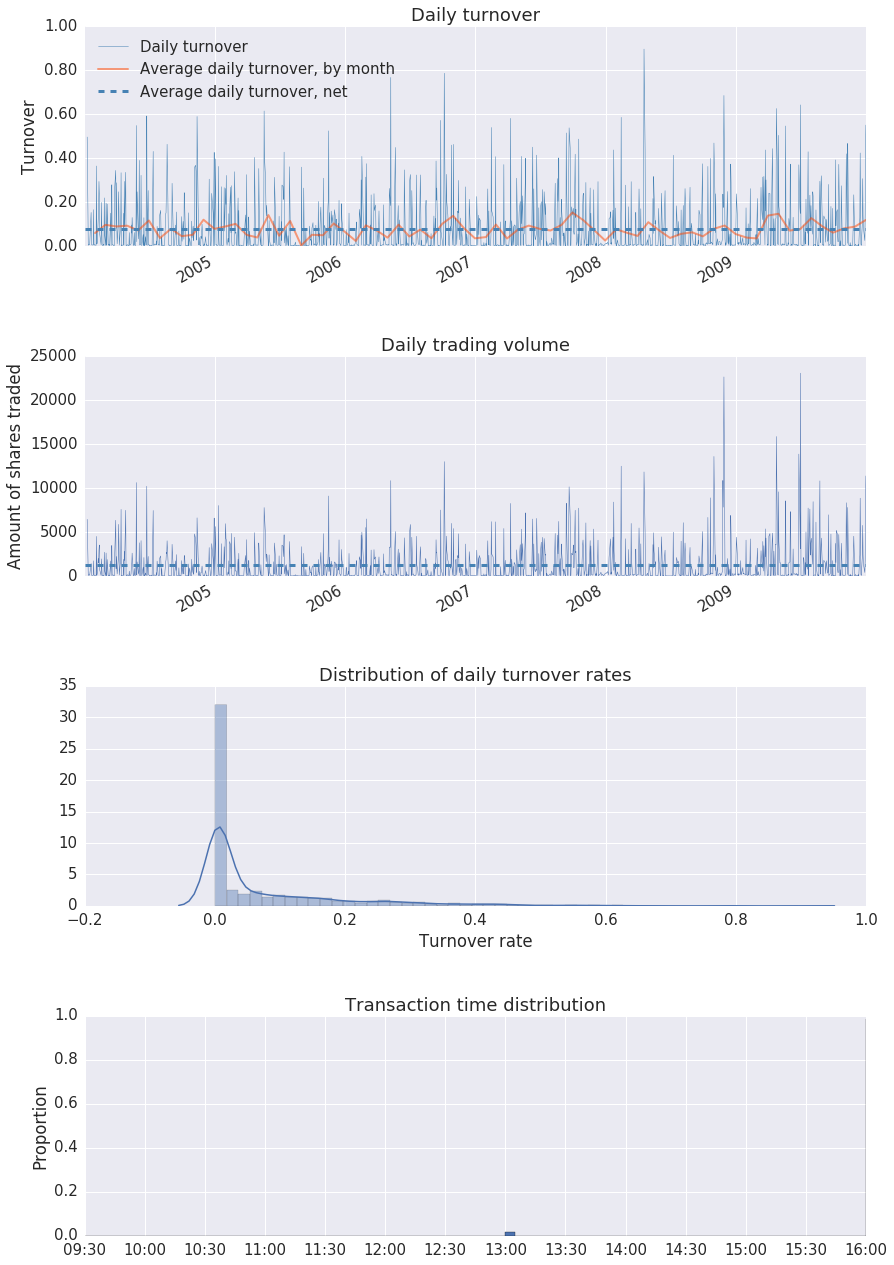

In [7]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', hide_positions=True)